In [1]:
import ee
import geemap
import datetime
import numpy as np
import matplotlib.pyplot as plt
from dateutil import tz

from sklearn.linear_model import LinearRegression

In [2]:
geemap.ee_initialize()
oeel = geemap.requireJS()
ee.Authenticate()
ee.Initialize(project='ee-amazyar-test1')

(node:31675) [DEP0040] DeprecationWarning: The `punycode` module is deprecated. Please use a userland alternative instead.
(Use `node --trace-deprecation ...` to show where the warning was created)


In [17]:
def M11_scale_to_celsius(modis_image: ee.image):
   scaled_lsts = modis_image.select(['LST_Day_1km', 'LST_Night_1km']).multiply(0.02).subtract(273.15).rename(['LST_Day', 'LST_Night'])
   return modis_image.addBands(srcImg=scaled_lsts)

def M21_scale_to_celsius(modis_image: ee.Image):
   scaled_lsts = modis_image.select(['LST_Day', 'LST_Night']).subtract(273.15)
   return modis_image.addBands(srcImg=scaled_lsts, overwrite=True)

m11_terra = ee.ImageCollection('MODIS/061/MOD11A2').map(lambda img: M11_scale_to_celsius(img))
m21_terra = ee.ImageCollection('MODIS/061/MOD21C2').map(lambda img: M21_scale_to_celsius(img))
m11_aqua = ee.ImageCollection('MODIS/061/MYD11A2').map(lambda img: M11_scale_to_celsius(img))
m21_aqua = ee.ImageCollection('MODIS/061/MYD21C2').map(lambda img: M21_scale_to_celsius(img))

m11_coll = m11_terra.merge(m11_aqua)
m21_coll = m21_terra.merge(m21_aqua)

In [24]:
date_start = ee.Date("2001-01-01") # в 2001 начал предоставлять тепловую информацию Terra
date_end = datetime.datetime.now()
baikal_shape = ee.FeatureCollection('projects/ee-amazyar-test/assets/baikal')

def get_average_lst_modis(modis_coll: ee.ImageCollection, start_time, end_time):
   if(modis_coll.size() == 0):
      return None
   mean_temp = modis_coll.filterDate(start_time, end_time).mean()
   day_night_temp = mean_temp.expression("(b('LST_Day') + b('LST_Night')) / 2").rename('LST')
   temp = day_night_temp.reduceRegion(reducer=ee.Reducer.median(), geometry=baikal_shape, scale=30, maxPixels=1000000000)
   result_dict = temp.getInfo()
   if(len(result_dict) == 0):
      return None
   return temp.getInfo()['LST']

In [23]:
start_time = ee.Date(f"2001-5-1")
end_time = ee.Date(f"2002-5-15")
m21_coll.filterDate(start_time, end_time).mean().getInfo()

{'type': 'Image',
 'bands': [{'id': 'Count_Day',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'Count_Night',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 65535},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'QC_Day',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'QC_Night',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': 0,
    'max': 255},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'LST_Day',
   'data_type': {'type': 'PixelType',
    'precision': 'double',
    'min': -273.15,
    'max': 1037.5500000000002},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]},
  {'id': 'LST_Night',
   'data_type': {'ty

In [21]:
lst_m21 = {}
lst_m11 = {}

for year in range(2001, 2025):
   lst_m21[year] = {}
   lst_m11[year] = {}
   for month in range(5, 12):
      start_date = ee.Date(f"{year}-{month}-1")
      if month == 5:
         end_date = ee.Date(f"{year}-5-15")
      else:
         end_date = ee.Date(f"{year}-{(month+1)}-1")
      
      result_m11 = get_average_lst_modis(m11_coll, start_date, end_date)
      # print(f"Complete M11 in {start_date} -- {end_date}")
      result_m21 = get_average_lst_modis(m21_coll, start_date, end_date)
      # print(f"Complete M21 in {start_date} -- {end_date}")
      if(result_m11 is not None):
         lst_m11[year][month] = result_m11
      if(result_m21 is not None):
         lst_m21[year][month] = result_m21
   
   lst_m11[year] = np.mean(list(lst_m11[year].values()))
   lst_m21[year] = np.mean(list(lst_m21[year].values()))
   if lst_m11[year] is None:
      del lst_m11[year]
   if lst_m21[year] is None:
      del lst_m21[year]

print(lst_m11, lst_m21)

Complete M11 in ee.Date({
  "functionInvocationValue": {
    "functionName": "Date",
    "arguments": {
      "value": {
        "constantValue": "2001-5-1"
      }
    }
  }
}) -- ee.Date({
  "functionInvocationValue": {
    "functionName": "Date",
    "arguments": {
      "value": {
        "constantValue": "2001-5-15"
      }
    }
  }
})


EEException: Image.select: Band pattern 'LST_Night' was applied to an Image with no bands. See https://developers.google.com/earth-engine/guides/debugging#no-bands

In [25]:
lst_m21 = {}
lst_m11 = {}

for year in range(2001, 2025):
   start_date = ee.Date(f"{year}-5-1")
   end_date = ee.Date(f"{year}-12-1")
   
   result_m11 = get_average_lst_modis(m11_coll, start_date, end_date)
   # print(f"Complete M11 in {start_date} -- {end_date}")
   result_m21 = get_average_lst_modis(m21_coll, start_date, end_date)
   # print(f"Complete M21 in {start_date} -- {end_date}")
   if(result_m11 is not None):
      lst_m11[year] = result_m11
   if(result_m21 is not None):
      lst_m21[year] = result_m21

print(lst_m11, lst_m21)

{2001: 5.842491396240383, 2002: 8.219332957023765, 2003: 5.656439602142641, 2004: 5.734869469992956, 2005: 6.531849339876437, 2006: 4.9060492860557, 2007: 7.2809330278051805, 2008: 6.533468533859902, 2009: 6.0305340331351625, 2010: 5.094210841389787, 2011: 5.967994345785269, 2012: 7.219104035994334, 2013: 5.905217261086823, 2014: 7.654669495055367, 2015: 7.531144386171869, 2016: 8.218349407005563, 2017: 6.593236922378059, 2018: 6.719189869141591, 2019: 7.094578957133895, 2020: 8.734443946453563, 2021: 5.828412341636187, 2022: 6.09309318815167, 2023: 7.390837815640571, 2024: 7.890600773747691} {2001: 4.31242926686882, 2002: 8.551497126106748, 2003: 5.982844689885509, 2004: 6.089400955514785, 2005: 7.047070691801201, 2006: 4.949340936085554, 2007: 7.637652151819811, 2008: 7.0170767054404335, 2009: 6.616908105510576, 2010: 5.465586714055236, 2011: 6.483764438663989, 2012: 7.800234700692724, 2013: 6.1754320703241, 2014: 8.173327475612094, 2015: 8.13942473151437, 2016: 9.096225829093385, 20

In [26]:
lst_m11

{2001: 5.842491396240383,
 2002: 8.219332957023765,
 2003: 5.656439602142641,
 2004: 5.734869469992956,
 2005: 6.531849339876437,
 2006: 4.9060492860557,
 2007: 7.2809330278051805,
 2008: 6.533468533859902,
 2009: 6.0305340331351625,
 2010: 5.094210841389787,
 2011: 5.967994345785269,
 2012: 7.219104035994334,
 2013: 5.905217261086823,
 2014: 7.654669495055367,
 2015: 7.531144386171869,
 2016: 8.218349407005563,
 2017: 6.593236922378059,
 2018: 6.719189869141591,
 2019: 7.094578957133895,
 2020: 8.734443946453563,
 2021: 5.828412341636187,
 2022: 6.09309318815167,
 2023: 7.390837815640571,
 2024: 7.890600773747691}

In [27]:
lst_m21

{2001: 4.31242926686882,
 2002: 8.551497126106748,
 2003: 5.982844689885509,
 2004: 6.089400955514785,
 2005: 7.047070691801201,
 2006: 4.949340936085554,
 2007: 7.637652151819811,
 2008: 7.0170767054404335,
 2009: 6.616908105510576,
 2010: 5.465586714055236,
 2011: 6.483764438663989,
 2012: 7.800234700692724,
 2013: 6.1754320703241,
 2014: 8.173327475612094,
 2015: 8.13942473151437,
 2016: 9.096225829093385,
 2017: 7.108458380351047,
 2018: 7.261674979787096,
 2019: 7.703103960025564,
 2020: 9.263830638771218,
 2021: 6.271545689745227,
 2022: 6.653172511657218,
 2023: 7.985421156061745,
 2024: 8.405748451754015}

In [28]:
lst_m11_s = {2001: 5.842491396240383,
 2002: 8.219332957023765,
 2003: 5.656439602142641,
 2004: 5.734869469992956,
 2005: 6.531849339876437,
 2006: 4.9060492860557,
 2007: 7.2809330278051805,
 2008: 6.533468533859902,
 2009: 6.0305340331351625,
 2010: 5.094210841389787,
 2011: 5.967994345785269,
 2012: 7.219104035994334,
 2013: 5.905217261086823,
 2014: 7.654669495055367,
 2015: 7.531144386171869,
 2016: 8.218349407005563,
 2017: 6.593236922378059,
 2018: 6.719189869141591,
 2019: 7.094578957133895,
 2020: 8.734443946453563,
 2021: 5.828412341636187,
 2022: 6.09309318815167,
 2023: 7.390837815640571,
 2024: 7.890600773747691}

lst_m21_s = {2001: 4.31242926686882,
 2002: 8.551497126106748,
 2003: 5.982844689885509,
 2004: 6.089400955514785,
 2005: 7.047070691801201,
 2006: 4.949340936085554,
 2007: 7.637652151819811,
 2008: 7.0170767054404335,
 2009: 6.616908105510576,
 2010: 5.465586714055236,
 2011: 6.483764438663989,
 2012: 7.800234700692724,
 2013: 6.1754320703241,
 2014: 8.173327475612094,
 2015: 8.13942473151437,
 2016: 9.096225829093385,
 2017: 7.108458380351047,
 2018: 7.261674979787096,
 2019: 7.703103960025564,
 2020: 9.263830638771218,
 2021: 6.271545689745227,
 2022: 6.653172511657218,
 2023: 7.985421156061745,
 2024: 8.405748451754015}

In [75]:
lst_landsat = { 2001: 5.656550599438131,
 2002: 8.320521618972615,
 2003: 6.091757048040242,
 2004: 5.7732563052208645,
 2005: 7.202113676953184,
 2006: 4.677950240759549,
 2007: 7.760961597024208,
 2008: 6.6034717455909435,
 2009: 4.557205862201402,
 2010: 3.6924846642136773,
 2011: 6.23094297749656,
 2012: 7.301778716924498,
 2013: 7.321033256423994,
 2014: 8.591829676073154,
 2015: 8.09153563179101,
 2016: 6.304393132929087,
 2017: 6.452240018513007,
 2018: 7.163009362965876,
 2019: 7.694713990514738,
 2020: 8.664525261832267,
 2021: 6.189892789413902,
 2022: 6.144092465190949,
 2023: 6.882291304703221,
 2024: 7.6525632439371005}

In [76]:
xs_m11 = np.array(list(lst_m11.keys())).reshape(-1, 1)
ys_m11 = np.array(list(lst_m11.values())).reshape(-1, 1)
xs_m21 = np.array(list(lst_m21.keys())).reshape(-1, 1)
ys_m21 = np.array(list(lst_m21.values())).reshape(-1, 1)
ys_m11 = np.array(list(lst_m11.values())).reshape(-1, 1)
xs_landsat = np.array(list(lst_landsat.keys())).reshape(-1, 1)
ys_landsat = np.array(list(lst_landsat.values())).reshape(-1, 1)

In [73]:
def plot_yearly_mean_multiple(year_coll, temp_coll, temp_colors, regression_colors, names):
   for (years, temperatures, line_color, regression_color, name) in zip(year_coll, temp_coll, temp_colors, regression_colors, names):
      regressor = LinearRegression().fit(years, temperatures)

      plt.plot(
         years,
         temperatures,
         linewidth=1.5,
         color=line_color,
         label=f"Данные {name}"
      )

      plt.plot(
         years,
         regressor.predict(years),
         linewidth=0.5,
         color=regression_color,
         label=f"Линейная регрессия {name}"
      )
      
   plt.legend(loc="upper left")

   plt.xticks(list(np.squeeze(year_coll[0])), rotation=300, ha='left')

   plt.xlabel(r"Год")
   plt.ylabel(r"Температура поверхностного слоя, ${\degree}C$")

   plt.gcf().set_size_inches(10, plt.gcf().get_size_inches()[1])

   plt.show()

In [ ]:
def plot_yearly_mean(years, temperatures, name):
   f, ax = plt.subplots()
   regressor = LinearRegression().fit(years, temperatures)

   plt.plot(
      years,
      temperatures,
      linewidth=1.5,
      color="black",
      label=f"Данные {name}"
   )

   plt.plot(
      years,
      regressor.predict(years),
      linewidth=0.5,
      color="black",
      label=f"Линейная регрессия {name}"
   )
   
   plt.legend(loc="upper left")

   plt.xticks(list(np.squeeze(years)), rotation=300, ha='left')
   
   plt.text(
      x=0.915,
      y=0.95,
      s=f"$\it{{Тренд = {regressor.coef_[0][0]:.2f}}}{{\degree}}C/год$",
      horizontalalignment='center',
      verticalalignment='top',
      transform = ax.transAxes, #
      bbox=dict(facecolor='white', alpha=0.2))

   plt.xlabel(r"Год")
   plt.ylabel(r"Температура поверхностного слоя, ${\degree}C$")

   plt.gcf().set_size_inches(10, plt.gcf().get_size_inches()[1])

   plt.show()

<>:28: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\d'
<>:28: SyntaxWarning: invalid escape sequence '\i'
<>:28: SyntaxWarning: invalid escape sequence '\d'


/tmp/ipykernel_31653/2910578889.py:28: SyntaxWarning: invalid escape sequence '\i'
  s=f"$\it{{Тренд = {regressor.coef_[0][0]:.2f}}}{{\degree}}C/год$",
/tmp/ipykernel_31653/2910578889.py:28: SyntaxWarning: invalid escape sequence '\d'
  s=f"$\it{{Тренд = {regressor.coef_[0][0]:.2f}}}{{\degree}}C/год$",


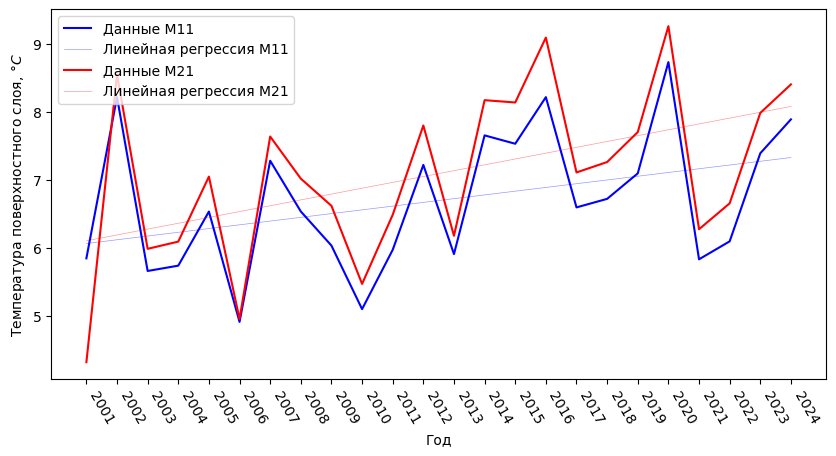

In [74]:
blue_transparent = (0,0,1,0.4)
red_transparent = (1,0,0,0.4)
plot_yearly_mean_multiple([xs_m11, xs_m21], [ys_m11, ys_m21], ['b','r'], [blue_transparent, red_transparent], ["M11", "M21"])

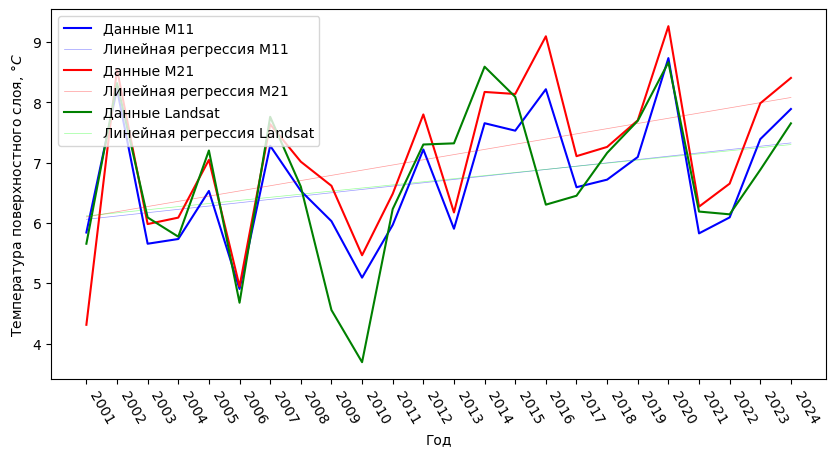

In [ ]:
blue_transparent = (0,0,1,0.4)
red_transparent = (1,0,0,0.4)
green_transparent = (0,1,0,0.4)
plot_yearly_mean_multiple([xs_m11, xs_m21, xs_landsat], [ys_m11, ys_m21, ys_landsat], ['b','r','g'], [blue_transparent, red_transparent, green_transparent], ["M11", "M21", "Landsat"])

In [79]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [84]:
n = 8
xs_m11_mean = running_mean(xs_m11, n).reshape(-1,1)
ys_m11_mean = running_mean(ys_m11, n).reshape(-1,1)
xs_m21_mean = running_mean(xs_m21, n).reshape(-1,1)
ys_m21_mean = running_mean(ys_m21, n).reshape(-1,1)
xs_landsat_mean = running_mean(xs_landsat, n).reshape(-1,1)
ys_landsat_mean = running_mean(ys_landsat, n).reshape(-1,1)

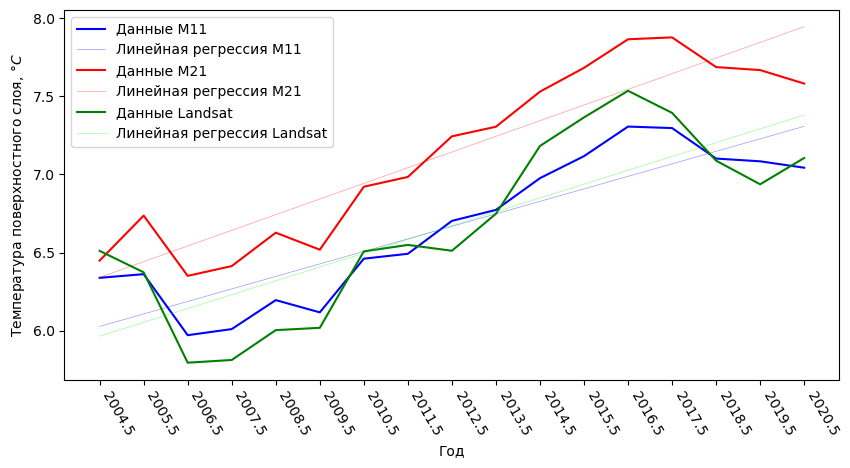

In [85]:
blue_transparent = (0,0,1,0.4)
red_transparent = (1,0,0,0.4)
green_transparent = (0,1,0,0.4)
plot_yearly_mean_multiple([xs_m11_mean, xs_m21_mean, xs_landsat_mean], [ys_m11_mean, ys_m21_mean, ys_landsat_mean], ['b','r','g'], [blue_transparent, red_transparent, green_transparent], ["M11", "M21", "Landsat"])

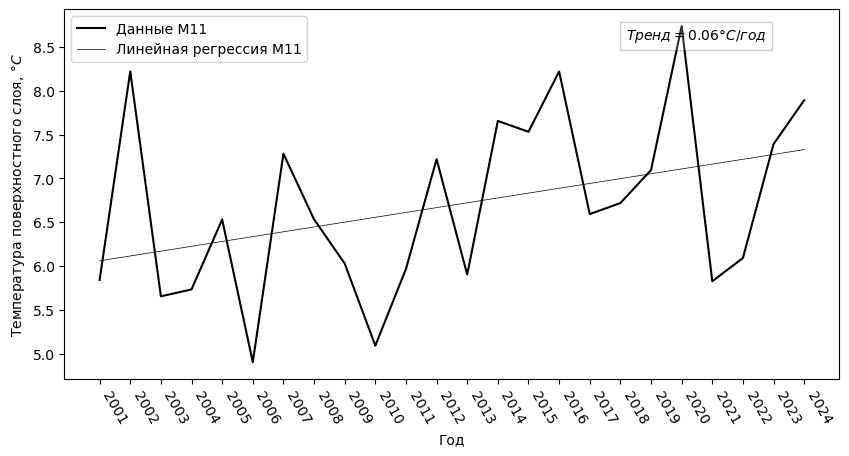

In [90]:
plot_yearly_mean(xs_m11, ys_m11, "M11")